# Deep Learning with Keras and TensorFlow
In this notebook I will walk through the basics for creating:  
1. an autoencoder, and  
2. a simple classifier  
using neural networks constructed with Keras and TensorFlow, two important libraries that were both born at Google.  
Both neural nets will have 2 hidden layers, so (just about) qualify as Deep Learning...

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

### Utility functions:

In [2]:
def nn_normalize(input_vector, centre=False, low=-1, high=1):
    """Normalize the input data for a neural network, so it lies between `low` and `high`. 
    Defaults are low = -1, high = 1. 
    If centre=True, then mean is fixed at 0 (hence distribution may not be symmetrical)"""
    absolute_max = max([low, high])
    if centre:
        # mean centre and ensure that nothing exceeds the limits
        scaled_vector = input_vector - np.mean(input_vector)
        scaled_vector = scaled_vector / np.max( abs(scaled_vector) )
        scaled_vector = scaled_vector * absolute_max
    else:
        # range scale
        scaled_vector = input_vector - input_vector.min()
        scaled_vector = ((scaled_vector * (high - low))/(scaled_vector.max())) - high
        
    return scaled_vector

def pandas_to_keras(pandas_dataframe):
    "Takes a pandas dataframe and makes it Keras-friendly"
    keras_array = pandas_dataframe.values.astype("float32")
    return(keras_array)

### Load the data
The breast cancer dataset is a classic and very easy binary classification dataset

In [3]:
from sklearn.datasets import load_breast_cancer
breast_cancer_data = load_breast_cancer()

In [4]:
print(breast_cancer_data['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [5]:
X = pd.DataFrame(breast_cancer_data['data'])
X.columns = breast_cancer_data['feature_names']

In [6]:
# X.head(20)

## Visualisation
First using PCA, and then tSNE  

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
breast_cancer_pca = pca.fit_transform(X)
breast_cancer_tsne = tsne.fit_transform(X)

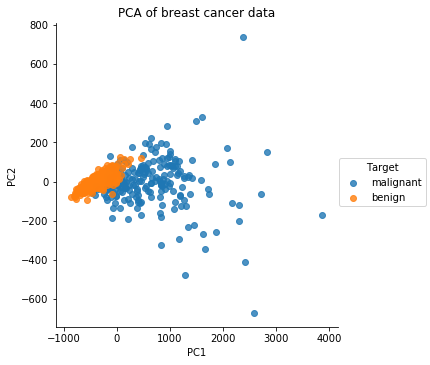

In [9]:
pca_df = pd.DataFrame(breast_cancer_pca, columns=["PC1", "PC2"])
pca_df['Target'] = [breast_cancer_data['target_names'][elt] for elt in breast_cancer_data['target']]
sns.lmplot(data=pca_df, x="PC1", y="PC2", hue="Target", fit_reg=False)
plt.title("PCA of breast cancer data")

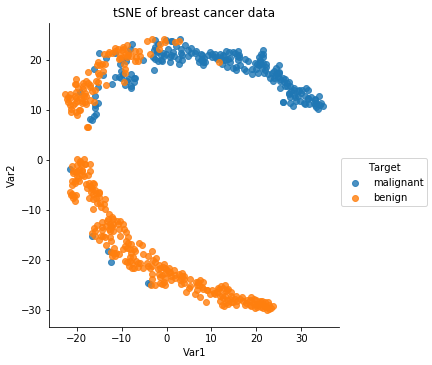

In [10]:
tsne_df = pd.DataFrame(breast_cancer_tsne, columns=["Var1", "Var2"])
tsne_df['Target'] = [breast_cancer_data['target_names'][elt] for elt in breast_cancer_data['target']]
sns.lmplot(data=tsne_df, x="Var1", y="Var2", hue="Target", fit_reg=False)
plt.title("tSNE of breast cancer data")

Before we do any modelling, we will split our data into a training and test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, breast_cancer_data['target'], test_size=0.2, random_state=123)

In [12]:
train_normalized = pandas_to_keras( X_train.apply(nn_normalize, axis=0) )
test_normalized = pandas_to_keras( X_test.apply(nn_normalize, axis=0) )

(array([  34.,  160.,  167.,   69.,   53.,   47.,   22.,    9.,    7.,    1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

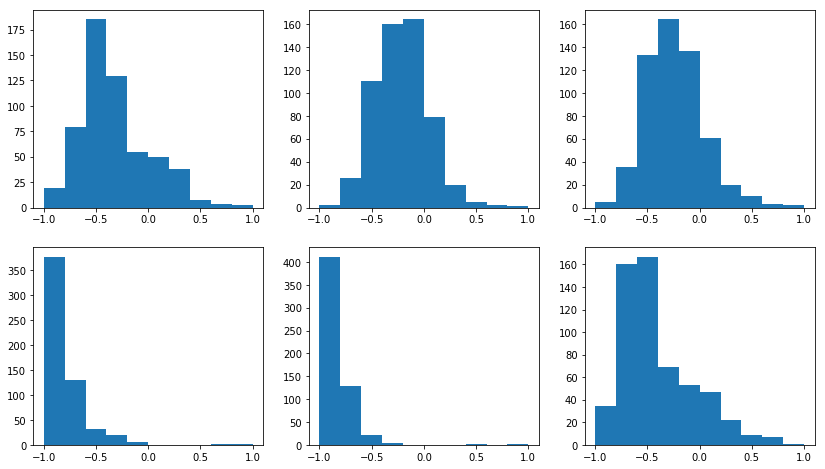

In [32]:
# let's just plot a couple of transformed variables and check they look right...
rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots(2,3)
ax[0,0].hist( nn_normalize(X.iloc[:,0]) )
ax[0,1].hist( nn_normalize(X.iloc[:,4]) )
ax[0,2].hist( nn_normalize(X.iloc[:,8]) )
ax[1,0].hist( nn_normalize(X.iloc[:,12]) )
ax[1,1].hist( nn_normalize(X.iloc[:,16]) )
ax[1,2].hist( nn_normalize(X.iloc[:,20]) )

### Now, let's build and an autoencoder
The architecture will be 30 - 16 - 2 - 30

In [14]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [15]:
# define the layers
number_of_variables = 30
input_layer = Input(shape=(number_of_variables,))
num_neurons_in_hidden_1 = 16
num_neurons_in_hidden_2 = 2
encoded = Dense(num_neurons_in_hidden_1, activation='tanh')(input_layer)
encoded = Dense(num_neurons_in_hidden_2, activation='tanh')(encoded)
decoded = Dense(number_of_variables, activation='tanh')(encoded)

In [16]:
# and the models
# the full autoencoder:
autoencoder = Model(input_layer, decoded)
# encoder only:
encoder = Model(input_layer, encoded)

In [17]:
autoencoder.compile(optimizer='sgd', loss='mse')

In [19]:
history = autoencoder.fit(x=train_normalized, y=train_normalized, 
                          epochs=1000, 
                          batch_size=32,
                          validation_data=(test_normalized, test_normalized))

Train on 455 samples, validate on 114 samples
Epoch 1/1000
455/455 [==============================] - 0s - loss: 0.4221 - val_loss: 0.3913
Epoch 2/1000
455/455 [==============================] - 0s - loss: 0.4034 - val_loss: 0.3781
Epoch 3/1000
455/455 [==============================] - 0s - loss: 0.3883 - val_loss: 0.3674
Epoch 4/1000
455/455 [==============================] - 0s - loss: 0.3763 - val_loss: 0.3589
Epoch 5/1000
455/455 [==============================] - 0s - loss: 0.3668 - val_loss: 0.3520
Epoch 6/1000
455/455 [==============================] - 0s - loss: 0.3589 - val_loss: 0.3461
Epoch 7/1000
455/455 [==============================] - 0s - loss: 0.3521 - val_loss: 0.34

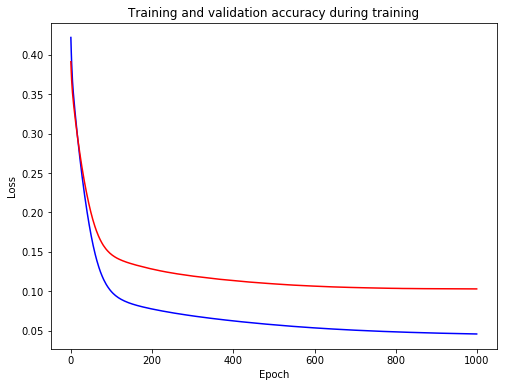

In [21]:
rcParams['figure.figsize'] = [8, 6]
plt.plot(range(1000), history.history['loss'], 'b-')
plt.plot(range(1000), history.history['val_loss'], 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and validation accuracy during training")

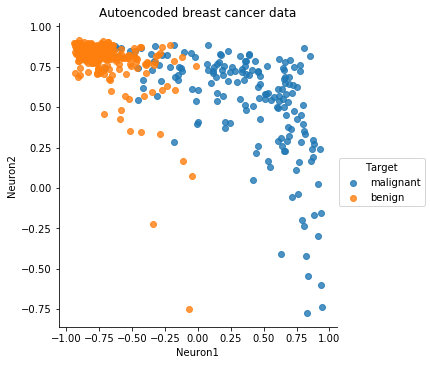

In [22]:
ae_df_train = pd.DataFrame(encoder.predict(train_normalized), columns=["Neuron1", "Neuron2"])
ae_df_train['Target'] = [breast_cancer_data['target_names'][elt] for elt in y_train]
sns.lmplot(data=ae_df_train, x="Neuron1", y="Neuron2", hue="Target", fit_reg=False)
plt.title("Autoencoded breast cancer data")

## Now, a classifier

In [23]:
# define the layers
number_of_variables = 30
input_layer_class = Input(shape=(number_of_variables,))
num_neurons_in_hidden_1 = 16
num_neurons_in_hidden_2 = 8

layers = Dense(num_neurons_in_hidden_1, activation='relu')(input_layer)
layers = Dense(num_neurons_in_hidden_2, activation='relu')(input_layer)
predictions = Dense(2, activation='softmax')(layers)

# This creates a model that includes
# the Input layer and three Dense layers
classifier = Model(inputs=input_layer, outputs=predictions)
classifier.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = classifier.fit(x=train_normalized, y=pd.get_dummies(y_train).as_matrix(), 
               epochs=1000, 
               batch_size=32,
               validation_data=(test_normalized, pd.get_dummies(y_test).as_matrix()))

Train on 455 samples, validate on 114 samples
Epoch 1/1000
455/455 [==============================] - 0s - loss: 0.6473 - acc: 0.6374 - val_loss: 0.6021 - val_acc: 0.6754
Epoch 2/1000
455/455 [==============================] - 0s - loss: 0.6157 - acc: 0.6462 - val_loss: 0.5770 - val_acc: 0.7105
Epoch 3/1000
455/455 [==============================] - 0s - loss: 0.5888 - acc: 0.6681 - val_loss: 0.5517 - val_acc: 0.7368
Epoch 4/1000
455/455 [==============================] - 0s - loss: 0.5641 - acc: 0.6813 - val_loss: 0.5290 - val_acc: 0.7456
Epoch 5/1000
455/455 [==============================] - 0s - loss: 0.5417 - acc: 0.6989 - val_loss: 0.5112 - val_acc: 0.7807
Epoch 6/1000
455/455 [==============================] - 0s - loss: 0.5192 - acc: 0.7231 - val_

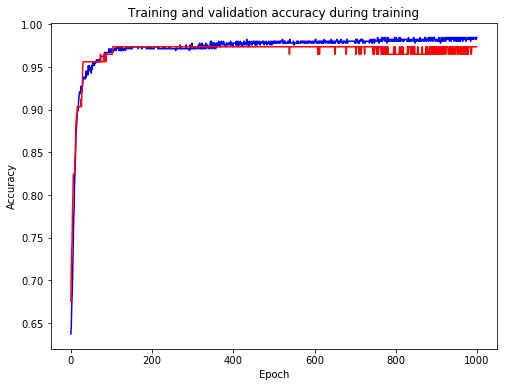

In [25]:
rcParams['figure.figsize'] = [8, 6]
plt.plot(range(1000), history.history['acc'], 'b-')
plt.plot(range(1000), history.history['val_acc'], 'r-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and validation accuracy during training")

In [26]:
train_accuracy = classifier.evaluate(train_normalized, y=pd.get_dummies(y_train).as_matrix())[1]
test_accuracy = classifier.evaluate(test_normalized, y=pd.get_dummies(y_test).as_matrix())[1]

 32/114 [=======>......................] - ETA: 0s

In [27]:
print("Accuracy on the training set was: {}".format(train_accuracy))
print("Accuracy on the test set was: {}".format(test_accuracy))

Accuracy on the training set was: 0.984615384615
Accuracy on the test set was: 0.973684206344
